Source: https://github.com/kailaix/nnpde

In [ ]:
!git clone https://github.com/kailaix/nnpde.git

Cloning into 'nnpde'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.


Running code

In [ ]:
%cd nnpde
!mkdir high

/content/nnpde


This code is based on tf1. To run in colab some modification is needed, which is already done in the code below.

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dens

Now step0
Now step1000
Now step2000
Now step3000
Now step4000
Now step5000
Now step6000
Now step7000
Now step8000
Now step9000


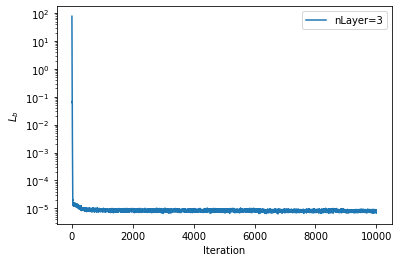

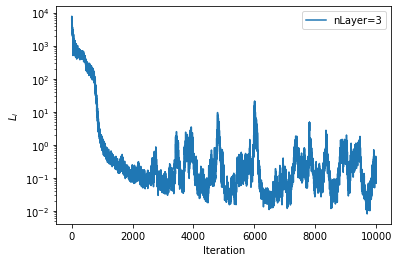

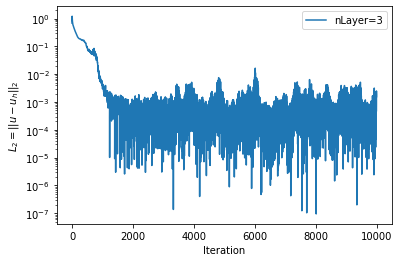

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
#from drawnow import drawnow, figure

def assert_shape(x, shape):
    S = x.get_shape().as_list()
    if len(S)!=len(shape):
        raise Exception("Shape mismatch: {} -- {}".format(S, shape))
    for i in range(len(S)):
        if S[i]!=shape[i]:
            raise Exception("Shape mismatch: {} -- {}".format(S, shape))

def compute_delta(u, x):
    grad = tf.gradients(u, x)[0]
    g1 = tf.gradients(grad[:,0], x)[0]
    g2 = tf.gradients(grad[:,1], x)[0]
    delta = g1[:,0] + g2[:,1]
    assert_shape(delta, (None,))
    return delta

def compute_delta_nd(u, x, n):
    grad = tf.gradients(u, x)[0]
    g1 = tf.gradients(grad[:, 0], x)[0]
    delta = g1[:,0]
    for i in range(1,n):
        g = tf.gradients(grad[:,i], x)[0]
        delta += g[:,i]
    assert_shape(delta, (None,))
    return delta

def compute_dx(u,x):
    grad = tf.gradients(u, x)[0]
    dudx = grad[:,0]
    assert_shape(dudx, (None,))
    return dudx

def compute_dy(u,x):
    grad = tf.gradients(u, x)[0]
    dudy = grad[:,1]
    assert_shape(dudy, (None,))
    return dudy


def rectspace(a,b,c,d,n):
    x = np.linspace(a,b,n)
    y = np.linspace(c,d,n)
    [X,Y] = np.meshgrid(x,y)
    return np.concatenate([X.reshape((-1, 1)), Y.reshape((-1, 1))], axis=1)

##
class NNPDE_ND:
    def __init__(self,batch_size, N, d): # d- dimension, N-number of layers
        self.d = d
        self.batch_size = batch_size
        self.N = N

        self.x = tf.placeholder(tf.float64, (None, d))  # inner data
        self.x_b = tf.placeholder(tf.float64, (None, d))  # boundary data

        self.u_b = self.bsubnetwork(self.x_b, False)
        self.u = self.bsubnetwork(self.x, True) + self.B(self.x) * self.subnetwork(self.x, False)

        self.bloss = tf.reduce_sum((self.tfexactsol(self.x_b) - self.u_b) ** 2)
        self.loss = self.loss_function()

        var_list1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "boundary")
        self.opt1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.bloss, var_list=var_list1)
        var_list2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inner")
        self.opt2 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss, var_list=var_list2)
        self.init = tf.global_variables_initializer()

        self.X_test = np.array([0.5]*self.d)[np.newaxis,:]

    def tfexactsol(self, x):
        raise NotImplementedError

    def exactsol(self, x):
        raise NotImplementedError

    def B(self, x):
        raise NotImplementedError

    def f(self, x):
        raise NotImplementedError

    def subnetwork(self, x, reuse = False):
        with tf.variable_scope("inner"):
            for i in range(self.N):
                x = tf.layers.dense(x, 256, activation=tf.nn.tanh, name="dense{}".format(i), reuse=reuse)
            x = tf.layers.dense(x, 1, activation=None, name="last", reuse=reuse)
            x = tf.squeeze(x, axis=1)
            assert_shape(x, (None,))
        return x

    def bsubnetwork(self, x, reuse = False):
        with tf.variable_scope("boundary"):
            for i in range(self.N):
                x = tf.layers.dense(x, 256, activation=tf.nn.tanh, name="bdense{}".format(i), reuse=reuse)
            x = tf.layers.dense(x, 1, activation=None, name="blast", reuse=reuse)
            x = tf.squeeze(x, axis=1)
            assert_shape(x, (None,))
        return x

    def loss_function(self):
        deltah = compute_delta_nd(self.u, self.x, self.d)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

    def compute_L2(self, sess, x):
        u0 = self.exactsol(x)
        u1 = sess.run(self.u, feed_dict={self.x: x})[0]
        return np.sqrt(np.mean((u0-u1)**2))



class NNPDE:
    def __init__(self, batch_size, N, refn):
        self.refn = refn  # reference points
        x = np.linspace(0, 1, refn)
        y = np.linspace(0, 1, refn)
        self.X, self.Y = np.meshgrid(x, y)
        self.refnX = np.concatenate([self.X.reshape((-1, 1)), self.Y.reshape((-1, 1))], axis=1)

        self.batch_size = batch_size  # batchsize
        self.N = N

        self.x = tf.placeholder(tf.float64, (None, 2))
        self.u = self.u_out(self.x)
        self.loss = self.loss_function()
        self.ploss = self.point_wise_loss()
        self.fig = plt.figure()

        self.opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        self.init = tf.global_variables_initializer()

    def exactsol(self, x, y):
        raise NotImplementedError

    # data to be modified
    def A(self, x):
        raise NotImplementedError

    def B(self, x):
        raise NotImplementedError

    def f(self, x):
        raise NotImplementedError

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

    # end modification

    def subnetwork(self, x):
        for i in range(self.N):
            x = tf.layers.dense(x, 256, activation=tf.nn.tanh)
        x = tf.layers.dense(x, 1, activation=None, name="last")
        x = tf.squeeze(x, axis=1)
        return x

    def u_out(self, x):
        res = self.A(x) + self.B(x) * self.subnetwork(x)
        assert_shape(res, (None,))
        return res

    def point_wise_loss(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.abs(deltah - delta)
        assert_shape(res, (None,))
        return res

    # def visualize(self, sess, showonlysol=False):

    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)

    #     uh = sess.run(self.u, feed_dict={self.x: self.refnX})
    #     Z = uh.reshape((self.refn, self.refn))

    #     uhref = self.exactsol(X, Y)

    #     def draw():
    #         ax = self.fig.gca(projection='3d')
    #         if not showonlysol:
    #             ax.plot_surface(X, Y, uhref, rstride=1, cstride=1, cmap=cm.autumn,
    #                             linewidth=0, antialiased=False, alpha=0.3)

    #         ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.summer,
    #                         linewidth=0, antialiased=False, alpha=0.8)
    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)
    #         ax.set_zlim(0, 1.1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')

    #     drawnow(draw)

    # def visualize_point_wise_loss(self, sess):
    #     ploss = sess.run(self.ploss, feed_dict={self.x: self.refnX})
    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)
    #     Z = ploss.reshape((self.refn, self.refn))

    #     def draw():
    #         ax = self.fig.gca(projection='3d')
    #         Z0 = np.log(Z + 1e-16) / np.log(10.0)
    #         Z0[Z0 < 1e-10] = 0
    #         ax.plot_surface(X, Y, Z0, rstride=1, cstride=1, cmap=cm.winter,
    #                         linewidth=0, antialiased=False)

    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')

    #     drawnow(draw)

    # def visualize_error(self, sess):
    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)
    #     uh = sess.run(self.u, feed_dict={self.x: np.concatenate([X.reshape((-1, 1)), Y.reshape((-1, 1))], axis=1)})
    #     Z = uh.reshape((self.refn, self.refn))

    #     def draw():
    #         ax = self.fig.gca(projection='3d')

    #         ax.plot_surface(X, Y, self.exactsol(X, Y) - Z, rstride=1, cstride=1, cmap=cm.winter,
    #                         linewidth=0, antialiased=False, alpha=0.85)

    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)
    #         ax.set_zlim(0, 1.1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')

    #     drawnow(draw)

    def train(self, sess, i=-1):
        # self.X = rectspace(0,0.5,0.,0.5,self.n)
        X = np.random.rand(self.batch_size, 2)
        _, loss = sess.run([self.opt, self.loss], feed_dict={self.x: X})
        if i % 10 == 0:
            print("Iteration={}, loss= {}".format(i, loss))

# u(x;w_1, w_2) = A(x;w_1) + B(x) * N(x;w_2)
# L u(x;w_1, w_2) = L A(x;w_1) + L( B(x) * N(x;w_2) ) --> f

class NNPDE2:
    def __init__(self, batch_size, N, refn):
        self.rloss = []
        self.rbloss = []
        self.rl2 = []

        self.refn = refn  # reference points
        x = np.linspace(0, 1, refn)
        y = np.linspace(0, 1, refn)
        self.X, self.Y = np.meshgrid(x, y)
        self.refX = np.concatenate([self.X.reshape((-1, 1)), self.Y.reshape((-1, 1))], axis=1)

        self.batch_size = batch_size  # batchsize
        self.N = N # number of dense layers

        self.x = tf.placeholder(tf.float64, (None, 2)) # inner data
        self.x_b = tf.placeholder(tf.float64, (None, 2)) # boundary data

        self.u_b = self.bsubnetwork(self.x_b, False)
        self.u = self.bsubnetwork(self.x, True) + self.B(self.x) * self.subnetwork(self.x, False)

        self.bloss = tf.reduce_sum((self.tfexactsol(self.x_b)-self.u_b)**2)
        self.loss = self.loss_function()

        self.ploss = self.point_wise_loss()



        var_list1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "boundary")
        self.opt1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.bloss,var_list=var_list1)
        var_list2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inner")
        self.opt2 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss, var_list=var_list2)
        self.init = tf.global_variables_initializer()


    def B(self, x):
        return x[:, 0] * (1 - x[:, 0]) * x[:, 1] * (1 - x[:, 1])

    def exactsol(self, x, y):
        raise NotImplementedError

    def tfexactsol(self, x):
        raise NotImplementedError

    def f(self, x):
        raise NotImplementedError

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

    # end modification

    def subnetwork(self, x, reuse = False):
        with tf.variable_scope("inner"):
            for i in range(self.N):
                x = tf.layers.dense(x, 256, activation=tf.nn.tanh, name="dense{}".format(i), reuse=reuse)
            x = tf.layers.dense(x, 1, activation=None, name="last", reuse=reuse)
            x = tf.squeeze(x, axis=1)
            assert_shape(x, (None,))
        return x

    def bsubnetwork(self, x, reuse = False):
        with tf.variable_scope("boundary"):
            for i in range(self.N):
                x = tf.layers.dense(x, 256, activation=tf.nn.tanh, name="bdense{}".format(i), reuse=reuse)
            x = tf.layers.dense(x, 1, activation=None, name="blast", reuse=reuse)
            x = tf.squeeze(x, axis=1)
            assert_shape(x, (None,))
        return x

    def point_wise_loss(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.abs(deltah - delta)
        assert_shape(res, (None,))
        return res

    def plot_exactsol(self):
        Z = self.exactsol(self.X, self.Y)
        ax = self.fig.gca(projection='3d')
        ax.plot_surface(self.X, self.Y, Z, rstride=1, cstride=1, cmap=cm.summer,
                        linewidth=0, antialiased=False, alpha=1.0)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')




    # def visualize(self, sess, showonlysol=False, i=None, savefig=None):

    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)

    #     uh = sess.run(self.u, feed_dict={self.x: self.refX})
    #     Z = uh.reshape((self.refn, self.refn))

    #     uhref = self.exactsol(X, Y)

    #     def draw():
    #         self.fig = plt.figure()
    #         ax = self.fig.gca(projection='3d')

    #         if not showonlysol:
    #             ax.plot_surface(X, Y, uhref, rstride=1, cstride=1, cmap=cm.autumn,
    #                             linewidth=0, antialiased=False, alpha=0.3)

    #         ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.summer,
    #                         linewidth=0, antialiased=False, alpha=0.5)
    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)
    #         ax.set_zlim(0, 1.1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')
    #         if i:
    #             plt.title("Iteration {}".format(i))
    #         if savefig:
    #             plt.savefig("{}/fig{}".format(savefig,0 if i is None else i))

    #     drawnow(draw)

    # def visualize_point_wise_loss(self, sess):
    #     ploss = sess.run(self.ploss, feed_dict={self.x: self.refnX})
    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)
    #     Z = ploss.reshape((self.refn, self.refn))

    #     def draw():
    #         ax = self.fig.gca(projection='3d')
    #         Z0 = np.log(Z + 1e-16) / np.log(10.0)
    #         Z0[Z0 < 1e-10] = 0
    #         ax.plot_surface(X, Y, Z0, rstride=1, cstride=1, cmap=cm.winter,
    #                         linewidth=0, antialiased=False)

    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')

    #     # drawnow(draw)
    #     draw()

    # def visualize_error(self, sess):
    #     x = np.linspace(0, 1, self.refn)
    #     y = np.linspace(0, 1, self.refn)
    #     [X, Y] = np.meshgrid(x, y)
    #     uh = sess.run(self.u, feed_dict={self.x: np.concatenate([X.reshape((-1, 1)), Y.reshape((-1, 1))], axis=1)})
    #     Z = uh.reshape((self.refn, self.refn))

    #     def draw():
    #         ax = self.fig.gca(projection='3d')

    #         ax.plot_surface(X, Y, self.exactsol(X, Y) - Z, rstride=1, cstride=1, cmap=cm.winter,
    #                         linewidth=0, antialiased=False, alpha=0.85)

    #         ax.set_xlim(0, 1)
    #         ax.set_ylim(0, 1)
    #         ax.set_zlim(0, 1.1)

    #         ax.set_xlabel('$x$')
    #         ax.set_ylabel('$y$')

    #     drawnow(draw)

    def train(self, sess, i=-1):
        # self.X = rectspace(0,0.5,0.,0.5,self.n)
        bX = np.zeros((4*self.batch_size, 2))
        bX[:self.batch_size,0] = np.random.rand(self.batch_size)
        bX[:self.batch_size,1] = 0.0

        bX[self.batch_size:2*self.batch_size, 0] = np.random.rand(self.batch_size)
        bX[self.batch_size:2*self.batch_size, 1] = 1.0

        bX[2*self.batch_size:3*self.batch_size, 0] = 0.0
        bX[2*self.batch_size:3*self.batch_size, 1] = np.random.rand(self.batch_size)

        bX[3*self.batch_size:4*self.batch_size, 0] = 1.0
        bX[3 * self.batch_size:4 * self.batch_size, 1] = np.random.rand(self.batch_size)

        bloss = sess.run([self.bloss], feed_dict={self.x_b: bX})[0]
        # if the loss is small enough, stop training on the boundary
        if bloss>1e-5:
            for _ in range(5):
                _, bloss = sess.run([self.opt1, self.bloss], feed_dict={self.x_b: bX})

        X = np.random.rand(self.batch_size, 2)
        _, loss = sess.run([self.opt2, self.loss], feed_dict={self.x: X})


        ########## record loss ############
        self.rbloss.append(bloss)
        self.rloss.append(loss)
        uh = sess.run(self.u, feed_dict={self.x: self.refX})
        Z = uh.reshape((self.refn, self.refn))
        uhref = self.exactsol(self.X, self.Y)
        self.rl2.append( np.sqrt(np.mean((Z-uhref)**2)) )
        ########## record loss ############


        if i % 10 == 0:
            print("Iteration={}, bloss = {}, loss= {}, L2={}".format(i, bloss, loss, self.rl2[-1]))

 ##
class Problem1(NNPDE):
    # data to be modified
    def exactsol(self,x,y):
        return np.sin(np.pi * x) * np.sin(np.pi * y)

    def A(self, x):
        return 0

    def B(self, x):
        return x[:, 0] * (1 - x[:, 0]) * x[:, 1] * (1 - x[:, 1])

    def f(self, x):
        return -2 * np.pi ** 2 * tf.sin(np.pi * x[:, 0]) * tf.sin(np.pi * x[:, 1])

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res
        # end modification
##
class Problem1_BD(NNPDE2):

    def exactsol(self,x,y):
        return np.sin(np.pi * x) * np.sin(np.pi * y)

    def tfexactsol(self,x):
        return tf.sin(np.pi * x[:,0]) * tf.sin(np.pi * x[:,1])


    def f(self, x):
        return -2 * np.pi ** 2 * tf.sin(np.pi * x[:, 0]) * tf.sin(np.pi * x[:, 1])

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

class ProblemPeak_BD(NNPDE2):
    def __init__(self, batch_size, N, refn):
        self.alpha = 1000
        self.xc = 0.5
        self.yc = 0.5
        NNPDE2.__init__(self,batch_size, N, refn)

    def bsubnetwork(self, x, reuse = False):
        with tf.variable_scope("boundary"):
            for i in range(self.N):
                x = tf.layers.dense(x, 256, activation=tf.nn.tanh, name="bdense{}".format(i), reuse=reuse)
            x = tf.layers.dense(x, 1, activation=None, name="blast", reuse=reuse)
            x = tf.squeeze(x, axis=1)
            assert_shape(x, (None,))
        return x

    # def loss_function(self):
    #     deltah = compute_delta(self.u, self.x)
    #     delta = self.f(self.x)
    #     delta = tf.clip_by_value(delta, -1e2, 1e2)
    #     deltah = tf.clip_by_value(deltah, -1e2, 1e2)
    #     res = tf.reduce_sum((deltah - delta) ** 2)
    #     assert_shape(res, ())
    #     return res

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        # delta = tf.clip_by_value(delta, -1e2, 1e2)
        # deltah = tf.clip_by_value(deltah, -1e2, 1e2)
        # weight = tf.clip_by_norm(1/delta**2, 10)
        # weight = tf.reduce_sum(delta**2)/delta**2
        res = tf.reduce_sum( 1/deltah**2 * (deltah - delta) ** 2)
        assert_shape(res, ())
        return res

    def exactsol(self, x, y):
        return np.exp(-self.alpha*((x-self.xc)**2+(y-self.yc)**2)) + np.sin(np.pi * x)

    def tfexactsol(self, x):
        return tf.exp(-1000 * ((x[:,0] - self.xc) ** 2 + (x[:,1] - self.yc) ** 2))+ tf.sin(np.pi * x[:,0])

    def f(self, x):
        return -4*self.alpha*self.tfexactsol(self.x) + 4*self.alpha**2*self.tfexactsol(self.x)* \
                                                       ((x[:, 0] - self.xc) ** 2 + (x[:, 1] - self.yc) ** 2) - np.pi**2 * tf.sin(np.pi * x[:,0])

    def train(self, sess, i=-1):
        # self.X = rectspace(0,0.5,0.,0.5,self.n)
        bX = np.zeros((4*self.batch_size, 2))
        bX[:self.batch_size,0] = np.random.rand(self.batch_size)
        bX[:self.batch_size,1] = 0.0

        bX[self.batch_size:2*self.batch_size, 0] = np.random.rand(self.batch_size)
        bX[self.batch_size:2*self.batch_size, 1] = 1.0

        bX[2*self.batch_size:3*self.batch_size, 0] = 0.0
        bX[2*self.batch_size:3*self.batch_size, 1] = np.random.rand(self.batch_size)

        bX[3*self.batch_size:4*self.batch_size, 0] = 1.0
        bX[3 * self.batch_size:4 * self.batch_size, 1] = np.random.rand(self.batch_size)

        for _ in range(5):
            _, bloss = sess.run([self.opt1, self.bloss], feed_dict={self.x_b: bX})

        X = np.random.rand(self.batch_size, 2)
        # if i>50:
        X = np.concatenate([X,rectspace(0.4,0.5,0.4,0.5,5)], axis=0)
        _, loss = sess.run([self.opt2, self.loss], feed_dict={self.x: X})

        if i % 10 == 0:
            print("Iteration={}, bloss = {}, loss= {}".format(i, bloss, loss))


class ProblemBLSingularity_BD(NNPDE2):
    def __init__(self, batch_size, N, refn):
        self.alpha = 0.6
        NNPDE2.__init__(self,batch_size, N, refn)

    def exactsol(self, x, y):
        return y**0.6

    def tfexactsol(self, x):
        return tf.pow(x[:,1],0.6)

    def f(self, x):
        return self.alpha*(self.alpha-1)*x[:,1]**(self.alpha-2)

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        delta = tf.clip_by_value(delta, -1e2, 1e2)
        deltah = tf.clip_by_value(deltah, -1e2, 1e2)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

class ProblemPeak(NNPDE):
    def __init__(self, batch_size, N, refn):
        self.alpha = 1000
        self.xc = 0.5
        self.yc = 0.5
        NNPDE.__init__(self,batch_size, N, refn)

    # data to be modified
    def exactsol(self,x,y):
        return np.exp(-1000 * ((x - self.xc) ** 2 + (y - self.yc) ** 2))

    def A(self, x):
        return tf.exp(-1000 * ((x[:,0] - self.xc) ** 2 + (x[:,1] - self.yc) ** 2)) +tf.sin(np.pi * x[:,0]) * tf.sin(np.pi * x[:,1])

    def B(self, x):
        return x[:, 0] * (1 - x[:, 0]) * x[:, 1] * (1 - x[:, 1])



    def tfexactsol(self, x):
        return tf.exp(-1000 * ((x[:,0] - self.xc) ** 2 + (x[:,1] - self.yc) ** 2))

    def f(self, x):
        return -4*self.alpha*self.tfexactsol(self.x) + 4*self.alpha**2*self.tfexactsol(self.x)* \
                                                       ((x[:, 0] - self.xc) ** 2 + (x[:, 1] - self.yc) ** 2)

    def loss_function(self):
        deltah = compute_delta(self.u, self.x)
        delta = self.f(self.x)
        res = tf.reduce_sum((deltah - delta) ** 2)
        assert_shape(res, ())
        return res

    def train(self, sess, i=-1):
        # self.X = rectspace(0,0.5,0.,0.5,self.n)
        X = np.random.rand(self.batch_size, 2)
        # X = np.concatenate([X, rectspace(0.4, 0.5, 0.4, 0.5, 5)], axis=0)
        _, loss = sess.run([self.opt, self.loss], feed_dict={self.x: X})
        if i % 10 == 0:
            print("Iteration={}, loss= {}".format(i, loss))



class ProblemBLSingularity(NNPDE):
    # data to be modified
    def exactsol(self,x,y):
        return x**0.6

    def A(self, x):
        return x[:,0]**0.6+tf.sin(np.pi * x[:,0]) * tf.sin(np.pi * x[:,1])

    def B(self, x):
        return x[:, 0] * (1 - x[:, 0]) * x[:, 1] * (1 - x[:, 1])

    def f(self, x):
        return 0.6*(0.6-1)*x[:,0]**(0.6-2)




# # dir = 'p1'
# # npde = Problem1_BD(64, 3, 50) # works very well
# # with tf.Session() as sess:
# #     sess.run(npde.init)
# #     for i in range(10000):
# #         if( i>1000 ):
# #             break
# #         npde.train(sess, i)
# #         if i%10==0:
# #             npde.visualize(sess, False, i=i, savefig=dir)
#
# dir = 'p2'
# npde = ProblemPeak_BD(64, 3, 50) # works very well
# # npde.plot_exactsol()
# # plt.show()
# # exit(0)
# with tf.Session() as sess:
#     sess.run(npde.init)
#     for i in range(10000):
#         if( i>1000 ):
#             break
#         npde.train(sess, i)
#         if i%10==0:
#             npde.visualize(sess, True, i=i, savefig=dir)
#
# # dir = 'p3'
# # npde = ProblemBLSingularity_BD(64, 3, 50) # works very well
# # with tf.Session() as sess:
# #     sess.run(npde.init)
# #     for i in range(10000):
# #         if( i>1000 ):
# #             break
# #         npde.train(sess, i)
# #         if i%50==0:
# #             npde.visualize(sess, False, i=i, savefig=dir)
#
#
# plt.close('all')
# plt.semilogy(npde.rbloss)
# plt.xlabel('Iteration')
# plt.ylabel('$L_b$')
# plt.savefig(dir + '/lb.png')
#
# plt.close('all')
# plt.semilogy(npde.rloss)
# plt.xlabel('Iteration')
# plt.ylabel('$L_i$')
# plt.savefig(dir + '/li.png')
#
# plt.close('all')
# plt.semilogy(npde.rl2)
# plt.xlabel('Iteration')
# plt.ylabel('$||u-u_h||_2$')
# plt.savefig(dir + '/l2.png')




## High dimension test
class HighDimension(NNPDE_ND):
    def tfexactsol(self,x):
        return tf.reduce_prod(tf.sin(np.pi * x), axis=1)

    def exactsol(self, x):
        return np.prod(np.sin(np.pi * x), axis=1)

    def f(self, x):
        return -np.pi**2*self.d* self.tfexactsol(x)

    def B(self, x):
        return tf.reduce_prod(x*(1-x),axis=1)

    def train(self, sess, i):
        self.rbloss = []
        self.rloss = []
        self.rl2 = []
        # self.X = rectspace(0,0.5,0.,0.5,self.n)
        bX = np.random.rand(2*self.d*self.batch_size, self.d)
        for j in range(self.d):
            bX[2*j*self.batch_size:(2*j+1)*self.batch_size, j] = 1.0
            bX[(2 * j+1) * self.batch_size:(2 * j + 2) * self.batch_size, j] = 0.0

        bloss = sess.run([self.bloss], feed_dict={self.x_b: bX})[0]
        # if the loss is small enough, stop training on the boundary
        if bloss>1e-5:
            for _ in range(5):
                _, bloss = sess.run([self.opt1, self.bloss], feed_dict={self.x_b: bX})

        X = np.random.rand(self.batch_size, self.d)
        _, loss = sess.run([self.opt2, self.loss], feed_dict={self.x: X})


        # ######### record loss ############
        self.rbloss.append(bloss)
        self.rloss.append(loss)
        self.rl2.append( self.compute_L2(sess, self.X_test) )
        # ######### record loss ############
        # loss = np.inf

        if i % 10 == 0:
        	pass
            #print("Iteration={}, bloss = {}, loss= {}, L2={}".format(i, bloss, loss, self.rl2[-1]))

##

# 1. tunable parameters: batch-size, number of layers
# 2. for different dimension, record bloss, loss, L2
# 3. generate meaningful plots

dir = './high/'


layers = [3]

from matplotlib import pyplot as plt
# import pickle
for dim in [3]:

    rblossFull = []
    rlossFull = []
    rl2Full = []
    for layer in layers:
        #print(layer)
        npde = HighDimension(64, layer, dim) # batch-size, number of layers, dimension
        rbloss = []
        rloss = []
        rl2 = []
        with tf.Session() as sess:

            sess.run(npde.init)
            for i in range(10000):
                if( i % 1000 == 0):
                    print('Now step'+ str(i))
                npde.train(sess, i)
                rbloss.append(npde.rbloss)
                rloss.append(npde.rloss)
                rl2.append(npde.rl2)
        #print(rbloss)
        #npde.visualize(sess, False, i=i, savefig=dir)
        tf.reset_default_graph()
        rblossFull.append(rbloss)
        rlossFull.append(rloss)
        rl2Full.append(rl2)

    with open(dir + str(dim) + '.txt', 'w') as file:
        for l in rblossFull:
            for item in l:
                file.write("%s," % item)
            file.write("\t")
        file.write("\n")
        for l in rlossFull:
            for item in l:
                file.write("%s," % item)
            file.write("\t")
        file.write("\n")
        for l in rl2Full:
            for item in l:
                file.write("%s," % item)
            file.write("\t")


    plt.close('all')
    plt.figure(1)
    for i in range(len(rblossFull)):
        plt.semilogy(rblossFull[i],label="nLayer=%d" %layers[i])
    plt.xlabel('Iteration')
    plt.ylabel('$L_b$')
    plt.legend()
    plt.savefig(dir + str(dim) + '_' 'lb.png')
    
    plt.figure(2)
    for i in range(len(rlossFull)):
        plt.semilogy(rlossFull[i],label="nLayer=%d"%layers[i])
    plt.xlabel('Iteration')
    plt.ylabel('$L_i$')
    plt.legend()
    plt.savefig(dir + str(dim) + '_' 'li.png')
    
    plt.figure(3)
    for i in range(len(rl2Full)):
        plt.semilogy(rl2Full[i],label="nLayer=%d"%layers[i])
    plt.xlabel('Iteration')
    plt.ylabel('$L_2 = ||u-u_h||_2$')
    plt.legend()
    plt.savefig(dir + str(dim) + '_' 'l2.png')
    plt.show()
    # /Users/shuyiyin/Dropbox/CS230_project/mcode
    # python nnpde.py           